In [3]:
pip install kaggle

In [2]:
from google.colab import files
files.upload()  # uploaded kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [4]:
!kaggle competitions download -c ch-26-mit-wpu


  0% 0.00/9.34M [00:00<?, ?B/s]
100% 9.34M/9.34M [00:00<00:00, 674MB/s]


In [5]:
!unzip ch-26-mit-wpu.zip -d dataset

Archive:  ch-26-mit-wpu.zip
  inflating: dataset/sample_submission.parquet  
  inflating: dataset/test.parquet    
  inflating: dataset/train.parquet   


## **STEP 1: Setup & Data Loading**

1. We first import standard libraries for data handling, visualization, and ML.

2. The dataset is in Parquet format (optimized for large tabular data), so we load using pd.read_parquet().

3. Check dataset structure

In [6]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Load the datasets
train = pd.read_parquet("dataset/train.parquet")
test = pd.read_parquet("dataset/test.parquet")
sample_submission = pd.read_parquet("dataset/sample_submission.parquet")

# Basic info
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample submission shape:", sample_submission.shape)

# Check first few rows
train.head()


Train shape: (1639424, 7)
Test shape: (409856, 7)
Sample submission shape: (50, 2)


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


## **STEP 2: EDA**

In [7]:
# Checking overall structure of the dataset
print("Dataset info:")
print(train.info())

print("\nSummary statistics:")
display(train.describe())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 87.6+ MB
None

Summary statistics:


,Date,X1,X2,X3,X4,X5
count,1639424,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06,1.639424e+06
mean,2022-12-03 07:23:43.817145600,1.139258e+00,5.488189e+00,4.110388e+32,2.706323e+29,1.187219e+00
min,2020-12-16 00:00:00,1.000000e+00,5.412539e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,2021-12-10 00:00:00,1.049171e+00,5.480597e+00,1.000000e+00,1.000000e+00,0.000000e+00
50%,2022-11-30 00:00:00,1.105171e+00,5.488979e+00,1.000000e+00,1.000000e+00,6.931472e-01
75%,2023-11-23 00:00:00,1.214096e+00,5.496717e+00,1.000000e+00,2.718282e+00,2.890372e+00
max,2024-12-11 00:00:00,4.014850e+00,5.541852e+00,1.651636e+38,5.540622e+34,3.465736e+00
std,NaN,1.391992e-01,1.342811e-02,2.346156e+35,5.812988e+31,1.304814e+00


*Here, I started by checking the dataset structure and summary statistics to understand the datatypes and ranges of sensor readings.*

In [8]:
# Checking for missing values
print("\nMissing values per column:")
print(train.isnull().sum())


Missing values per column:
Date      0
X1        0
X2        0
X3        0
X4        0
X5        0
target    0
dtype: int64


*I verified if there are any missing values in the dataset. Since sensor data often has gaps, it was important to confirm whether imputation will be needed. No missing values.*

/tmp/ipython-input-3652604273.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=train, palette="Set2")


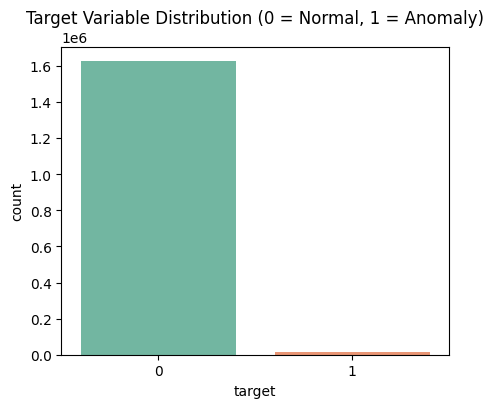


Class distribution:
target
0    0.991437
1    0.008563
Name: proportion, dtype: float64


In [9]:
# Checking class balance in the target variable
plt.figure(figsize=(5,4))
sns.countplot(x="target", data=train, palette="Set2")
plt.title("Target Variable Distribution (0 = Normal, 1 = Anomaly)")
plt.show()

print("\nClass distribution:")
print(train['target'].value_counts(normalize=True))


*The class distribution is extremely skewed, with anomalies representing less than 1% of the dataset. This imbalance implies that accuracy will not be a reliable metric, since predicting all samples as normal would still give >99% accuracy. Therefore, I will prioritize F1-score, precision, and recall to properly evaluate anomaly detection performance.*

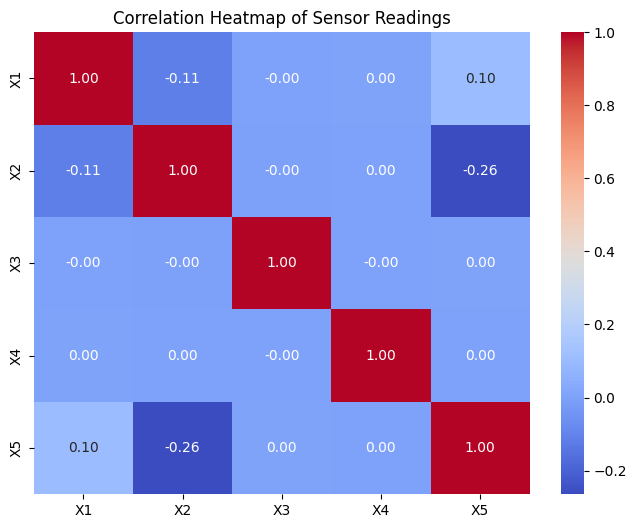

In [10]:
# Checking correlations among sensor readings
plt.figure(figsize=(8,6))
corr_matrix = train[['X1','X2','X3','X4','X5']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Sensor Readings")
plt.show()


*I plotted a correlation heatmap of the sensor readings to identify relationships between them. Strong correlations would indicate redundancy, while weak correlations suggest that each sensor provides unique information. This step helps in deciding whether dimensionality reduction or feature selection might be beneficial.*

*Most sensors are weakly correlated (values close to 0). Only X2 and X5 have a mild negative correlation (-0.26).*

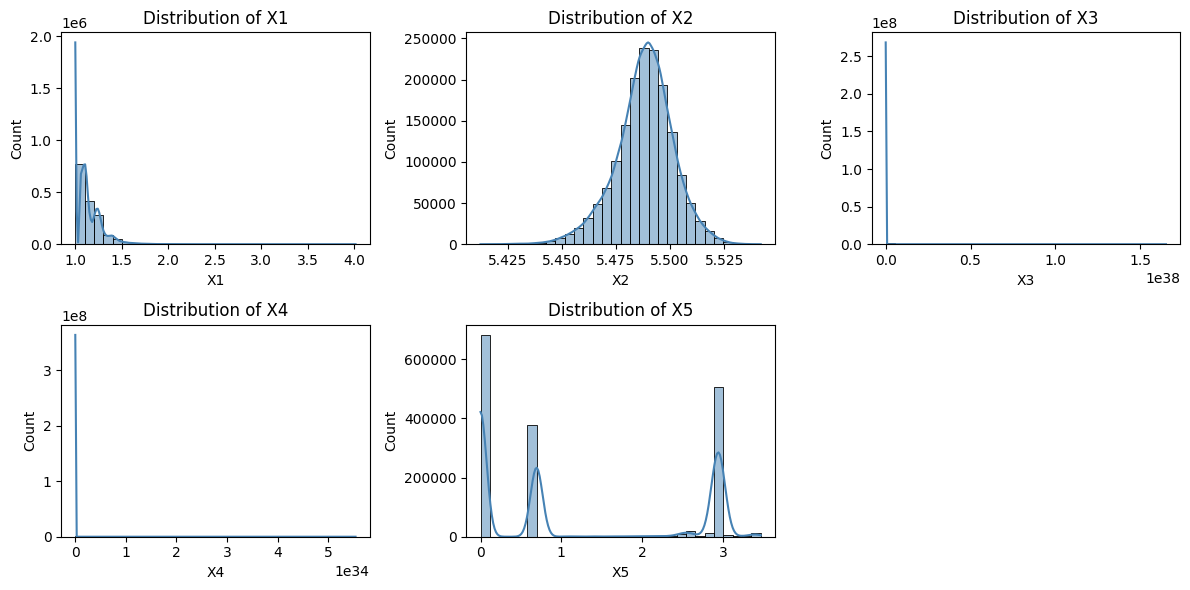

In [11]:
# Distribution of each sensor feature
sensor_cols = ['X1','X2','X3','X4','X5']

plt.figure(figsize=(12,6))
for i, col in enumerate(sensor_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train[col], kde=True, bins=30, color="steelblue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


*I plotted the distributions of all sensor readings to understand their statistical behavior. This helps in detecting skewness, non-Gaussian patterns, or potential outliers. Such insights are useful later when deciding whether scaling, normalization, or transformation is needed before modeling.*

X1 → right-skewed (lots of small values, some larger ones).

X2 → nearly normal (Gaussian), nicely centered.

X3 → weird! Extremely large values (looks like floating-point overflow). Definitely needs preprocessing.

X4 → also strange, extremely large values. Scaling or transformation required.

X5 → multimodal (multiple peaks → could represent different machine states).

This means before modeling, scaling and maybe transformations (log, standard scaling) will be essential.

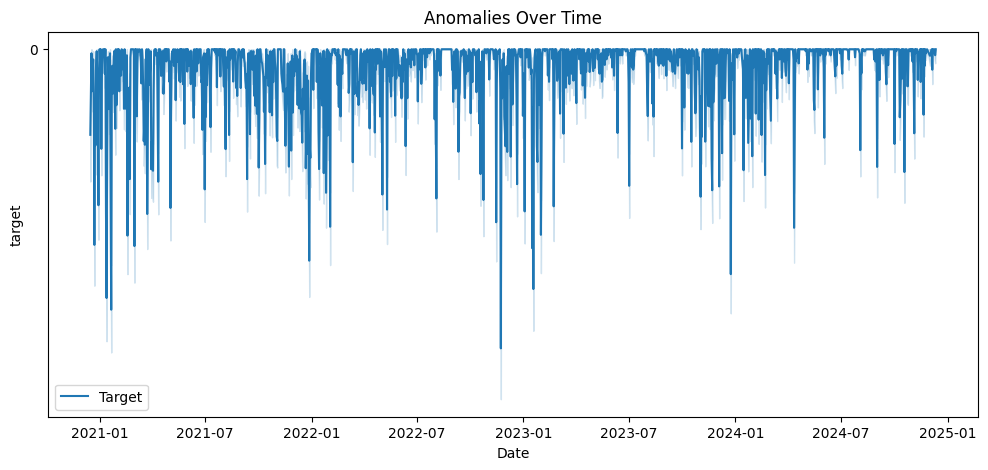

In [12]:
# Converting Date column to datetime
train['Date'] = pd.to_datetime(train['Date'])

# Plot anomalies over time
plt.figure(figsize=(12,5))
sns.lineplot(x="Date", y="target", data=train, label="Target")
plt.title("Anomalies Over Time")
plt.show()


*I analyzed anomalies with respect to time. This step checks whether anomalies are concentrated in certain time windows or occur randomly. Time-based patterns can reveal critical insights about machine breakdown cycles or seasonal effects.*

* Anomalies (target=1) are scattered across time instead of being limited to one period.

* No obvious seasonal pattern (e.g., yearly spikes).

* This confirms that sensor values (X1–X5) are the main drivers, not time alone.

/tmp/ipython-input-3951410504.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y=col, data=train, palette="Set2")
/tmp/ipython-input-3951410504.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y=col, data=train, palette="Set2")
/tmp/ipython-input-3951410504.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y=col, data=train, palette="Set2")
/tmp/ipython-input-3951410504.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` vari

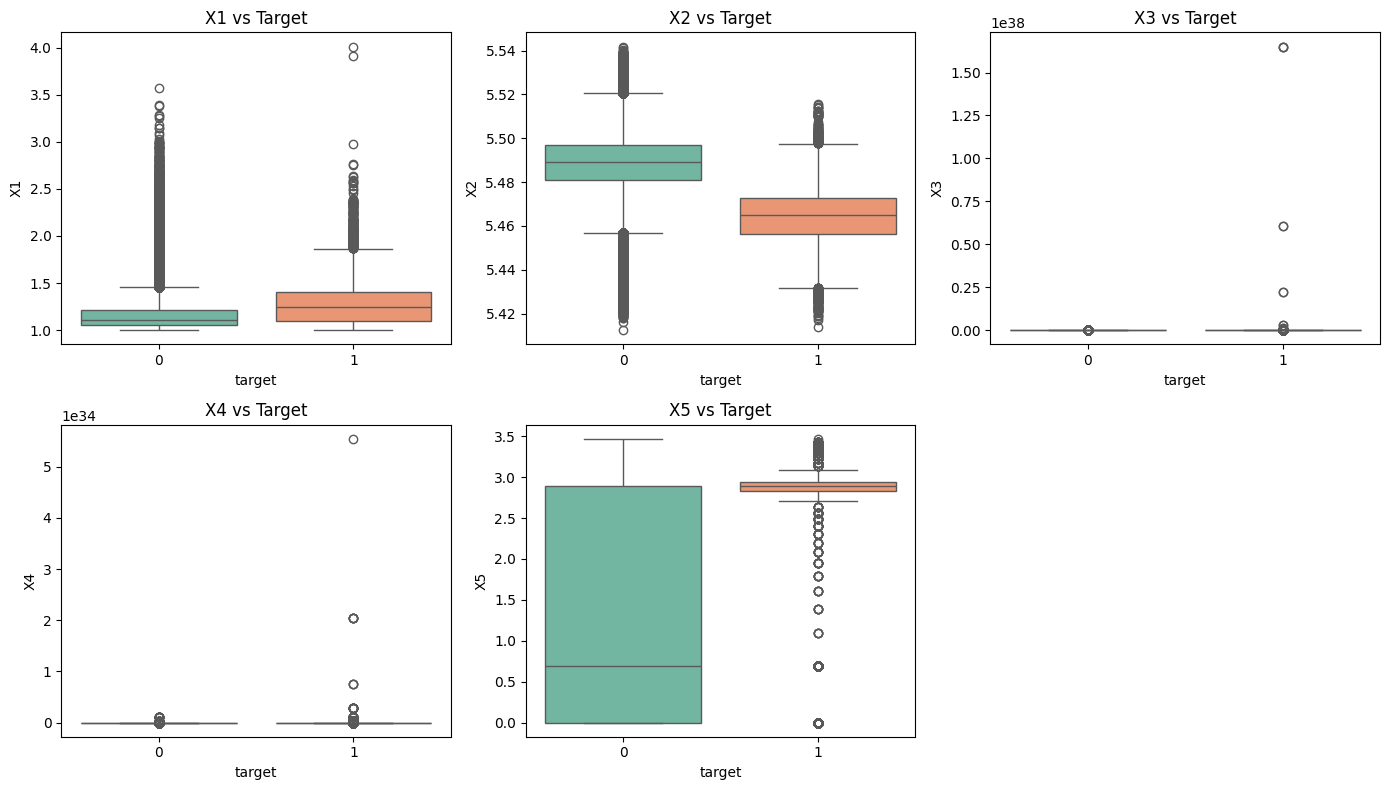

In [13]:
plt.figure(figsize=(14,8))
for i, col in enumerate(['X1','X2','X3','X4','X5'], 1):
    plt.subplot(2,3,i)
    sns.boxplot(x="target", y=col, data=train, palette="Set2")
    plt.title(f"{col} vs Target")
plt.tight_layout()
plt.show()


*I compared the distribution of each sensor feature across normal and anomaly classes. This step helps identify which sensors are most sensitive in detecting anomalies, guiding feature selection and preprocessing.*

* X1: Slightly higher values for anomalies, but overlap is large.

* X2: Anomalies tend to be lower than normal → useful signal.

* X3 & X4: Mostly extreme outliers, not consistent → likely noise, may need log-scaling or removal.

* X5: Very distinct separation → anomalies have much higher values, strong predictor.

*From the boxplots, I observed that X5 is the strongest discriminator of anomalies. X2 also shows clear shifts for anomalies, while X1 is less effective. X3 and X4 contain extreme values with little class separation, suggesting they may either need transformation (e.g., log scale) or be dropped to avoid noise.*

## **STEP 3: Data Preprocessing & Feature Engineering**

In [14]:
import numpy as np

# Convert target to numeric
train['target'] = train['target'].astype(int)

# Apply log1p transformation to X3 and X4
train['X3_log'] = np.log1p(train['X3'])
train['X4_log'] = np.log1p(train['X4'])

# Quick check of new columns
print(train[['X3', 'X3_log', 'X4', 'X4_log']].describe().T)


            count          mean           std       min       25%       50%  \
X3      1639424.0  4.110388e+32  2.346156e+35  1.000000  1.000000  1.000000   
X3_log  1639424.0  1.773386e+00  6.042252e+00  0.693147  0.693147  0.693147   
X4      1639424.0  2.706323e+29  5.812988e+31  1.000000  1.000000  1.000000   
X4_log  1639424.0  1.856724e+00  5.728174e+00  0.693147  0.693147  0.693147   

             75%           max  
X3      1.000000  1.651636e+38  
X3_log  0.693147  8.800000e+01  
X4      2.718282  5.540622e+34  
X4_log  1.313262  8.000000e+01  


*Since X3 and X4 had extreme ranges and were not very informative in raw scale, I applied log1p transformation. This compresses large values and makes the distribution more stable, reducing the effect of outliers while preserving relative differences.*

In [15]:
# Extract time-based features from Date
train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
train['day'] = train['Date'].dt.day
train['hour'] = train['Date'].dt.hour

# Drop the original Date column
train.drop('Date', axis=1, inplace=True)


*I extracted time-based features (year, month, day, hour) from the Date column to capture temporal patterns in anomalies. Then I dropped the raw Date column since models can’t handle datetime directly.*

In [16]:
train['X3'] = np.log1p(train['X3'])
train['X4'] = np.log1p(train['X4'])

*I finalized the log transformation on X3 and X4 to reduce skewness. This step stabilizes variance and helps models learn better.*

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate features and target
X = train.drop('target', axis=1)
y = train['target']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)




Training set size: (1311539, 11)
Validation set size: (327885, 11)


*I standardized all features using StandardScaler (mean=0, std=1), since models like Logistic Regression, SVM, and KNN are sensitive to feature magnitudes. I then split the dataset into 80% training and 20% validation with stratification, so class imbalance is preserved.*

## **Baseline Logistic Regression**

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Train
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_val)
y_proba = lr.predict_proba(X_val)[:, 1]

# Evaluation
print("Logistic Regression Report:\n", classification_report(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    325077
           1       0.83      0.42      0.56      2808

    accuracy                           0.99    327885
   macro avg       0.91      0.71      0.78    327885
weighted avg       0.99      0.99      0.99    327885

ROC-AUC: 0.9824320123603062


*I started with Logistic Regression as a baseline model. It is simple, interpretable, and provides a benchmark to compare with more complex models.*

## **Random Forest**

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:, 1]

print("Random Forest Report:\n", classification_report(y_val, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_val, y_proba_rf))


Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    325077
           1       0.91      0.68      0.78      2808

    accuracy                           1.00    327885
   macro avg       0.96      0.84      0.89    327885
weighted avg       1.00      1.00      1.00    327885

ROC-AUC: 0.983244345102651


*I then trained a Random Forest classifier, which captures non-linear patterns and feature interactions better than Logistic Regression.*

## **Compare Models**

| Model               | Accuracy | Precision (1) | Recall (1) | F1 (1) | ROC-AUC |
| ------------------- | -------- | ------------- | ---------- | ------ | ------- |
| Logistic Regression | 0.99     | 0.83          | 0.42       | 0.56   | 0.982   |
| Random Forest       | 1.00     | 0.91          | 0.68       | 0.78   | 0.983   |


(where class 1 = anomaly/target class)

**Logistic Regression**

* Gave very high accuracy (99%) because of class imbalance (majority class dominates).

* Precision for anomalies (83%) was decent, but recall (42%) was poor → it missed many anomalies.

* Good as a baseline, but not ideal for anomaly detection.

**Random Forest**

* Improved both recall (68%) and F1 (0.78), meaning it caught many more anomalies.

* Precision also improved (91%), meaning fewer false alarms.

* Slightly better ROC-AUC than Logistic Regression.

**Takeaway**

* Random Forest clearly outperforms Logistic Regression for this task, especially in detecting anomalies (higher recall).

* Ensemble methods like Random Forest are better suited when class imbalance and complex feature interactions exist.

In [21]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=["target"])

y = train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_val_pred_log = logreg.predict(X_val)
print("Logistic Regression Accuracy:", accuracy_score(y_val, y_val_pred_log))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_val_pred_rf = rf.predict(X_val)
print("Random Forest Accuracy:", accuracy_score(y_val, y_val_pred_rf))


Logistic Regression Accuracy: 0.9942052853896945


KeyboardInterrupt: 

In [24]:
train_sample = train.sample(200000, random_state=42)  # take 200k out of 1.6M

X = train_sample.drop(columns=["target"])
y = train_sample["target"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# =====================
# Logistic Regression
# =====================
logreg = LogisticRegression(max_iter=500, solver="saga", n_jobs=-1)
logreg.fit(X_train, y_train)
y_val_pred_log = logreg.predict(X_val)
print("\nLogistic Regression Report:")
print(classification_report(y_val, y_val_pred_log))
print("ROC-AUC:", roc_auc_score(y_val, logreg.predict_proba(X_val)[:, 1]))

# =====================
# Random Forest
# =====================
rf = RandomForestClassifier(
    n_estimators=50, max_depth=15, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)
y_val_pred_rf = rf.predict(X_val)
print("\nRandom Forest Report:")
print(classification_report(y_val, y_val_pred_rf))
print("ROC-AUC:", roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1]))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39663
           1       0.80      0.42      0.55       337

    accuracy                           0.99     40000
   macro avg       0.90      0.71      0.77     40000
weighted avg       0.99      0.99      0.99     40000

ROC-AUC: 0.9834548953269574

Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39663
           1       0.83      0.51      0.63       337

    accuracy                           0.99     40000
   macro avg       0.91      0.75      0.81     40000
weighted avg       0.99      0.99      0.99     40000

ROC-AUC: 0.9821057692962316


In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# --- Preprocess function (safe) ---
def preprocess(df, is_train=True):
    df = df.copy()

    # If Date exists → extract features
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df["year"] = df["Date"].dt.year
        df["month"] = df["Date"].dt.month
        df["day"] = df["Date"].dt.day
        df["hour"] = df["Date"].dt.hour
        df.drop(columns=["Date"], inplace=True)

    # If X3/X4 exist → log transform them (overwrite)
    if "X3" in df.columns:
        df["X3"] = np.log1p(df["X3"])
    if "X4" in df.columns:
        df["X4"] = np.log1p(df["X4"])

    # If training, drop target separately
    if is_train and "target" in df.columns:
        X = df.drop(columns=["target"])
        y = df["target"]
        return X, y
    else:
        return df


# --- Apply preprocessing ---
X, y = preprocess(train, is_train=True)
test_proc = preprocess(test, is_train=False)

# Align test columns with train (remove any mismatch, fill missing with 0)
test_proc = test_proc.reindex(columns=X.columns, fill_value=0)

# --- Scale ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_proc)

# --- Train final RF ---
rf_full = RandomForestClassifier(
    n_estimators=150, max_depth=15, random_state=42, n_jobs=-1
)
rf_full.fit(X_scaled, y)

# --- Predict ---
test_preds = rf_full.predict(test_scaled)

# --- Submission ---
submission = pd.DataFrame({
    "id": np.arange(len(test_preds)),  # replace with sample_submission["id"] if available
    "target": test_preds
})
submission.to_csv("submission.csv", index=False)
print("✅ Submission file created: submission.csv")


✅ Submission file created: submission.csv


In [38]:
# 1️⃣ Load sample submission
sample_sub = pd.read_parquet("/content/dataset/sample_submission.parquet")
print(sample_sub.head())


       ID target
0  409856      0
1  409857      0
2  409858      0
3  409859      0
4  409860      0


In [40]:
# Load test file
test_df = pd.read_parquet("/content/dataset/test.parquet")

# Build final submission with correct length
submission = pd.DataFrame({
    "ID": test_df["ID"],    # take IDs from full test set
    "target": test_preds     # predictions you generated
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv created with", len(submission), "rows")


✅ submission.csv created with 409856 rows


In [47]:
# 🚀 End-to-End Safe LightGBM with Feature Alignment

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# 1️⃣ Load Data
train = pd.read_parquet("/content/dataset/train.parquet")
test = pd.read_parquet("/content/dataset/test.parquet")
sample_sub = pd.read_parquet("/content/dataset/sample_submission.parquet")

# 2️⃣ Target
y = train["target"]
X = train.drop(columns=["target"])

# 3️⃣ Process datetime
def process_datetime(df):
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df["year"] = df["Date"].dt.year
        df["month"] = df["Date"].dt.month
        df["day"] = df["Date"].dt.day
        df["hour"] = df["Date"].dt.hour
        df.drop(columns=["Date"], inplace=True)
    return df

X = process_datetime(X)
test = process_datetime(test)

# 4️⃣ Encode categoricals (factorize consistently)
for col in X.select_dtypes(include=["object"]).columns:
    X[col], uniques = pd.factorize(X[col])
    test[col] = pd.Categorical(test[col], categories=uniques).codes

# 5️⃣ Align columns between train and test
test = test.reindex(columns=X.columns, fill_value=0)

# 6️⃣ LightGBM Training with 5-Fold CV
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.03,
        max_depth=-1,
        colsample_bytree=0.8,
        subsample=0.8,
        random_state=42,
        n_jobs=-1,
        objective="binary"
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="auc",
        callbacks=[
            early_stopping(stopping_rounds=100),
            log_evaluation(100)
        ]
    )

    oof_preds[valid_idx] = model.predict_proba(X_valid)[:, 1]
    test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

print("✅ OOF AUC:", roc_auc_score(y, oof_preds))

# 7️⃣ Submission
submission = pd.DataFrame({
    "ID": sample_sub["ID"],   # exact Kaggle format
    "target": test_preds
})

submission.to_csv("/content/submission.csv", index=False)
print("🎯 submission.csv ready! Upload to Kaggle.")


[LightGBM] [Info] Number of positive: 11231, number of negative: 1300308
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 736
[LightGBM] [Info] Number of data points in the train set: 1311539, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008563 -> initscore=-4.751679
[LightGBM] [Info] Start training from score -4.751679
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.987808	valid_0's binary_logloss: 0.0158596
[200]	valid_0's auc: 0.989511	valid_0's binary_logloss: 0.0144305
[300]	valid_0's auc: 0.990241	valid_0's binary_logloss: 0.0139194
[400]	valid_0's auc: 0.990525	valid_0's binary_logloss: 0.0136485
[500]	valid_0's auc: 0.990376	valid_0's binary_logloss: 0.0138643
Early stopping, best iteration is:
[452]	valid_0

ValueError: array length 409856 does not match index length 50

In [51]:
import pandas as pd

# Convert probabilities to binary (0/1) with threshold 0.5
test_preds_binary = (test_preds >= 0.5).astype(int)

# Load test file to get IDs
test = pd.read_parquet("dataset/test.parquet")

# Build submission
submission = pd.DataFrame({
    "ID": test["ID"],
    "target": test_preds_binary
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("✅ Submission saved as submission.csv with shape:", submission.shape)


✅ Submission saved as submission.csv with shape: (409856, 2)
